In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from grating import *

In [2]:
%config IPCompleter.use_jedi = False

In [3]:
epsilon_Si = 13.491
epsilon_SiO2 = 2.085136
n_freqs = 200
freqs = np.linspace(0.15, 0.25, n_freqs)
n_grating_layers = 15

In [4]:
fname = 'dataset.npz'
with np.load(fname) as data:
    designs = data['D']
    responses = data['R']
    
n_grating_layers = designs.shape[-1]
n_freqs = responses.shape[-1]
Dtrain, Dtest, Rtrain, Rtest = train_test_split(designs, responses,
                                                test_size=0.1,
                                                random_state=42)
print("Train set contains {} samples".format(Dtrain.shape[0]))
print("Validation set contains {} samples".format(Dtest.shape[0]))

Train set contains 588429 samples
Validation set contains 65381 samples


In [5]:
load_dir = 'forward_model'
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

fmodel = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs4000_Adam0001_Sigmoid.h5'),
    custom_objects={'loss': loss})

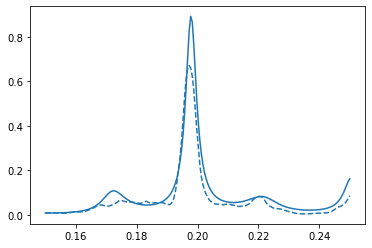

In [6]:
np.random.seed(42)
D = np.random.random_sample((1, n_grating_layers))
gr = Grating(epsilon_Si, epsilon_SiO2, D[0])
fig, ax = plt.subplots()
line, = ax.plot(freqs, gr.transmittivity(freqs))
ax.plot(freqs, fmodel(D)[0].numpy(), '--', color=line.get_color())

In [7]:
activation = keras.activations.sigmoid
inputs = layers.Input((n_freqs,), name='R')
I1 = layers.Dense(500, activation=activation, name='I1')
I2 = layers.Dense(200, activation=activation, name='I2')
I3 = layers.Dense(n_grating_layers, activation=activation, name='D', dtype=np.double)
imodel = keras.Sequential([inputs, I1, I2, I3], name='InverseNet')
imodel.summary()

Model: "InverseNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I1 (Dense)                   (None, 500)               100500    
_________________________________________________________________
I2 (Dense)                   (None, 200)               100200    
_________________________________________________________________
D (Dense)                    (None, 15)                3015      
Total params: 203,715
Trainable params: 203,715
Non-trainable params: 0
_________________________________________________________________


In [8]:
imodel.load_weights(os.path.join('inverse_model',
                                 'Epochs400_Adam0001_Sigmoid.h5'))

In [9]:
tandem = keras.Model(inputs, fmodel(imodel(inputs)),
                    name='TandemNet')
tandem.layers[-1].trainable = False
tandem.summary()

Model: "TandemNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
R (InputLayer)               [(None, 200)]             0         
_________________________________________________________________
InverseNet (Sequential)      (None, 15)                203715    
_________________________________________________________________
ForwardNet (Sequential)      (None, 200)               228800    
Total params: 432,515
Trainable params: 203,715
Non-trainable params: 228,800
_________________________________________________________________


In [10]:
tandem.compile(loss=loss, optimizer='adam')

In [11]:
initial_epoch = 400

info = tandem.fit(Rtrain, Rtrain,
                 batch_size=128, epochs=1 + initial_epoch,
                 validation_data=(Rtest, Rtest),
                 validation_freq=5,
                 initial_epoch=initial_epoch)

initial_epoch = tandem.history.epoch[-1]

Epoch 401/401
4598/4598 [==============================] - 13s 3ms/step - loss: 0.8048


In [12]:
epochs = initial_epoch + 1
imodel.save(os.path.join('inverse_model',
                 'Epochs{}_Adam0001_Sigmoid.h5'.format(epochs)))

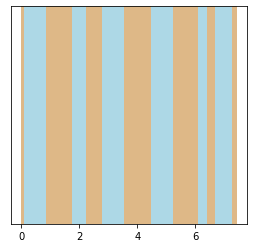

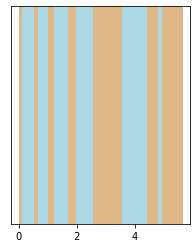

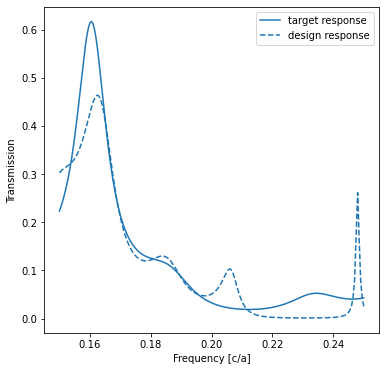

In [13]:
seed = 33
np.random.seed(seed)

idx = np.random.randint(0, Rtest.shape[0], 1)
dnn_designs = [Grating(epsilon_Si, epsilon_SiO2, d) for d in imodel(Rtest[idx]).numpy()]
true_designs = [Grating(epsilon_Si, epsilon_SiO2, d) for d in  Dtest[idx]]
for o, d in zip(dnn_designs, true_designs):
    o.plot()
#     plt.savefig('grating_design_seed{}.png'.format(seed), dpi=200)
    d.plot()
#     plt.savefig('grating_true_seed{}.png'.format(seed), dpi=200)

fig, ax = plt.subplots(figsize=(6,6))
line, = ax.plot(freqs, d.transmittivity(freqs), label='target response')
ax.plot(freqs, o.transmittivity(freqs), '--', color=line.get_color(), label='design response')
ax.set_xlabel('Frequency [c/a]')
ax.set_ylabel('Transmission')
ax.legend()
# plt.savefig('tandemNN_seed{}.png'.format(seed), dpi=200)

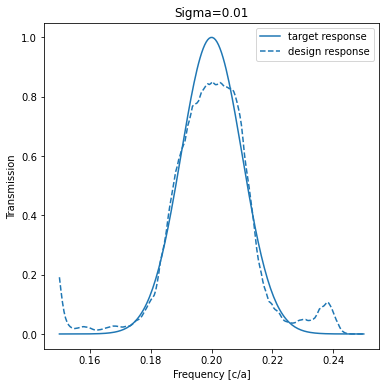

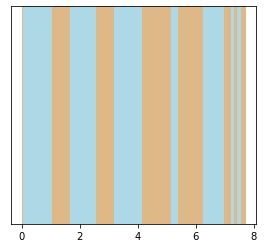

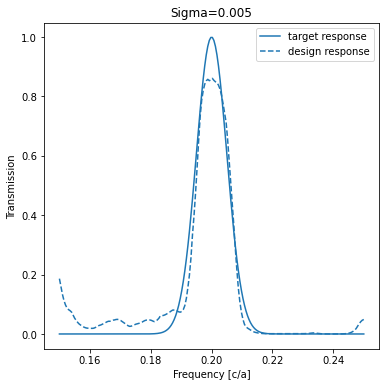

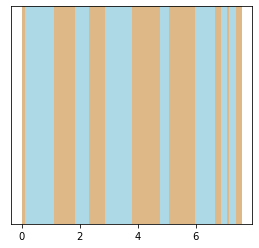

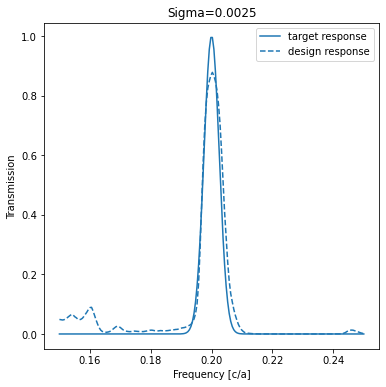

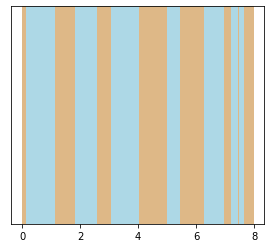

In [14]:
# design of structures with Gaussian responses
sigma = [0.01, 0.005, 0.0025]
fc = 0.2
R_Gauss = np.zeros((len(sigma),len(freqs)))
for i in range(len(sigma)):
    R_Gauss[i] = np.exp(-(freqs-fc)**2/2/sigma[i]**2)
R_predicted = tandem(R_Gauss).numpy()
D_predicted = [Grating(epsilon_Si, epsilon_SiO2, d) for d in imodel(R_Gauss).numpy()]

for i in range(len(sigma)):
    fig, ax = plt.subplots(figsize=(6,6))
    line, = ax.plot(freqs, R_Gauss[i], label='target response')
    ax.plot(freqs, R_predicted[i], '--', color=line.get_color(), label='design response')
    ax.set_xlabel('Frequency [c/a]')
    ax.set_ylabel('Transmission')
    ax.set_title('Sigma={}'.format(sigma[i]))
    ax.legend()
    D_predicted[i].plot()
#     plt.savefig('tandemNN_Gauss_fit_sigma{}.png'.format(i+1), dpi=200)